# Bias-Variance tradeoff example from the Mumford et al. 2011
Jörn Diedrichsen (jdiedric@uwo.ca) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

### Problem of regressors with covariance (overlapping trial hrf's)
Here we use a an example of overlapping hrfs and i.i.d noise - Autocorrelated noise (and associatated temporal prewhitening) does not change anything fundamental. First let's make a Design matrix with 4 different trials - all overlapping. For simplicity I am using here a hrf with [1,0.5]. 

In [2]:
## Construct design matrix 
def make_design(hrf,seq,iti):
    h=len(hrf)
    N=len(seq)*iti+len(hrf)-1
    Q=len(seq)
    X=np.zeros((N,Q))
    for i in range(Q):
        start = i*iti
        X[start:start+h,seq[i]]=hrf
    return X

Now we can make the design matrix for a standard run with 4 trials. 

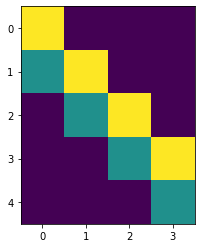

In [3]:
hrf=[1,0.5]
seq = [0,1,2,3]
X = make_design([1,0.5],[0,1,2,3],1)
plt.imshow(X)

The first panel shows the covariance between regressors, the second one the variance of the estimatated beta weights 

Text(0.5, 1.0, '$(\\mathbf{X}^T\\mathbf{X})^{-1}$')

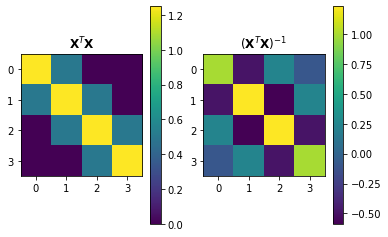

In [4]:
plt.subplot(1,2,1)
plt.imshow(X.T@X)
plt.colorbar()
plt.title('$\mathbf{X}^T\mathbf{X}$')
plt.subplot(1,2,2)
plt.imshow(la.inv(X.T@X))
plt.colorbar()
plt.title('$(\mathbf{X}^T\mathbf{X})^{-1}$')


So how bad is the covariance? We can calculate the Variance-inflation factor - the ratio of the variance that we got over the variance we would expect if we had widely spaced the trials and made them independent. 

In [5]:
var1 = 1/np.diag(X.T@X)
var2 = np.diag(la.inv(X.T@X))
print(f'Variance without overlap: {var1}')
print(f'Variance with overlap:{var2.round(3)}')
VIF = var2/var1
print(f'Variance inflation:{VIF.round(3)}')


Variance without overlap: [0.8 0.8 0.8 0.8]
Variance with overlap:[0.997 1.232 1.232 0.997]
Variance inflation:[1.246 1.54  1.54  1.246]


## The proposed solution 
The idea is to combine all other trial types into one single regressor and then estimate the single one that you want. 
Here we show that this can actually can be expressed simply with a new combination of the old original regressors. 

Say you have a simple GLM with pretty extensive design matrix (superset): 
$$
\mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \epsilon\\
\hat{\boldsymbol{\beta}}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}
$$
Then you are interested in a linear subspace, i.e. the projection on a arbitrary new design matrix: 
$$
\mathbf{Z}=\mathbf{XC}
$$
Then you can simply obtain any new beta estimate by re-weighting the old estimates

$$
\boldsymbol{\gamma}=(\mathbf{C}^T\mathbf{X}^T\mathbf{X}\mathbf{C})^{-1}\mathbf{C}^T\mathbf{X}^T\mathbf{y}\\
=(\mathbf{C}^T\mathbf{X}^T\mathbf{X}\mathbf{C})^{-1}\mathbf{C}^T\mathbf{X}^T\mathbf{X}\hat{\boldsymbol{\beta}}\\
$$

### Example: Variance reduction
So say we want to estimate the second trial type, we can define the following contrast matrix. 

In [6]:
C = np.array([[0,1,0,0],[1,0,1,1]]).T
C


array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1]])

The new design matrix will now look something like this:  

Text(0.5, 1.0, 'New design matrix')

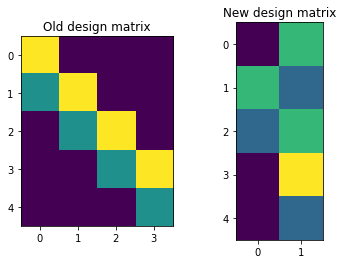

In [7]:
plt.subplot(1,2,1)
plt.imshow(X)
plt.title('Old design matrix')
plt.subplot(1,2,2)
plt.imshow(X@C)
plt.title('New design matrix')


In [8]:
var1=np.diag(la.inv(X.T@X))
var2=np.diag(la.inv(C.T@X.T@X@C))
print(f'Old Variance: {var1[1].round(3)}')
print(f'New Variance: {var2[0].round(3)}')


Old Variance: 1.232
New Variance: 0.962


### Example: Increase in bias (inducing variance across blocks)
Very predictably, the decrease in variance doesn't come for free (nothing good in life really does). The simpler model assumes that all the other trials elicit exactly the same activity. What if this not the case. Let's assume the true activity of the 2 trial (we are interested in) is 1. The activity of one of the other trials is also 1, but 2 other conditions have an activity of 2 and 3.  

In [9]:
b=np.array([[1,1,2,3],[1,1,3,2],[2,1,1,3],[2,1,3,1],[3,1,1,2],[3,1,2,1]]).T
b

array([[1, 1, 2, 2, 3, 3],
       [1, 1, 1, 1, 1, 1],
       [2, 3, 1, 3, 1, 2],
       [3, 2, 3, 1, 2, 1]])

We can now directly express the estimation of the new parameters as the function of the old betas by defining projection matrix P

$$
\mathbf{P}= (\mathbf{C}^T \mathbf{X}^T \mathbf{X} \mathbf{C})^{-1} \mathbf{C}^T \mathbf{X}^T \mathbf{X}
$$

In [10]:
P=la.inv(C.T@X.T@X@C)@C.T@X.T@X
P.round(3)

array([[ 0.228,  1.   ,  0.127, -0.354],
       [ 0.215,  0.   ,  0.342,  0.443]])

In [11]:
(P@b).round(3)

array([[0.418, 0.899, 0.519, 1.481, 1.101, 1.582],
       [2.228, 2.127, 2.101, 1.899, 1.873, 1.772]])

So, in this example, the estimates vary between 0.4 and 1.58. This is due to the different ordering of trials in the different runs and model doesn't account for it. If the ordering is completely random, the estimator is still unbiased. However, the variance consists of two parts: The estimation uncertainty and average deviation of the conditions from the mean, with the desired $\gamma_i$ excepted. 

$$
\mathbf{M} = \frac{1}{K-1} \sum_{j \neq i} (\beta_j - \bar{\beta})^2\\
\mathbf{V} = (\mathbf{C_i}^T \mathbf{X}^T \mathbf{X} \mathbf{C_i})^{-1}\\
var(\gamma_i) =  V_{ii} + \mathbf{P}_i \mathbf{V} \mathbf{P_i} 
$$